## Importing packages

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import re
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Pobieranie danych z kaggle

In [13]:
train = pd.read_csv("data/pzn-rent-train.csv")
test = pd.read_csv("data/pzn-rent-test.csv")
submit = pd.read_csv("data/pzn-sample-sub.csv")

## Analiza eksploracyjna

In [14]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11297 entries, 0 to 11296
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11297 non-null  int64  
 1   ad_title            11297 non-null  object 
 2   date_activ          11297 non-null  object 
 3   date_modif          11297 non-null  object 
 4   date_expire         11297 non-null  object 
 5   individual          10194 non-null  object 
 6   price               11297 non-null  int64  
 7   flat_area           10080 non-null  float64
 8   flat_rooms          10070 non-null  float64
 9   flat_furnished      9980 non-null   object 
 10  flat_rent           11297 non-null  int64  
 11  flat_deposit        11297 non-null  float64
 12  flat_for_students   9493 non-null   object 
 13  building_floor_num  11297 non-null  int64  
 14  flat_balcony        9929 non-null   object 
 15  flat_utility_room   11297 non-null  bool   
 16  flat

In [15]:
print(train.describe(include='all'))

                  id                   ad_title  date_activ  date_modif  \
count   11297.000000                      11297       11297       11297   
unique           NaN                       9114        1216         511   
top              NaN  Mieszkanie, 50 m², Poznań  2020-09-02  2020-09-23   
freq             NaN                         62          51         133   
mean     8210.438878                        NaN         NaN         NaN   
std      4729.098948                        NaN         NaN         NaN   
min         1.000000                        NaN         NaN         NaN   
25%      4115.000000                        NaN         NaN         NaN   
50%      8206.000000                        NaN         NaN         NaN   
75%     12282.000000                        NaN         NaN         NaN   
max     16448.000000                        NaN         NaN         NaN   

       date_expire individual         price     flat_area    flat_rooms  \
count        11297      

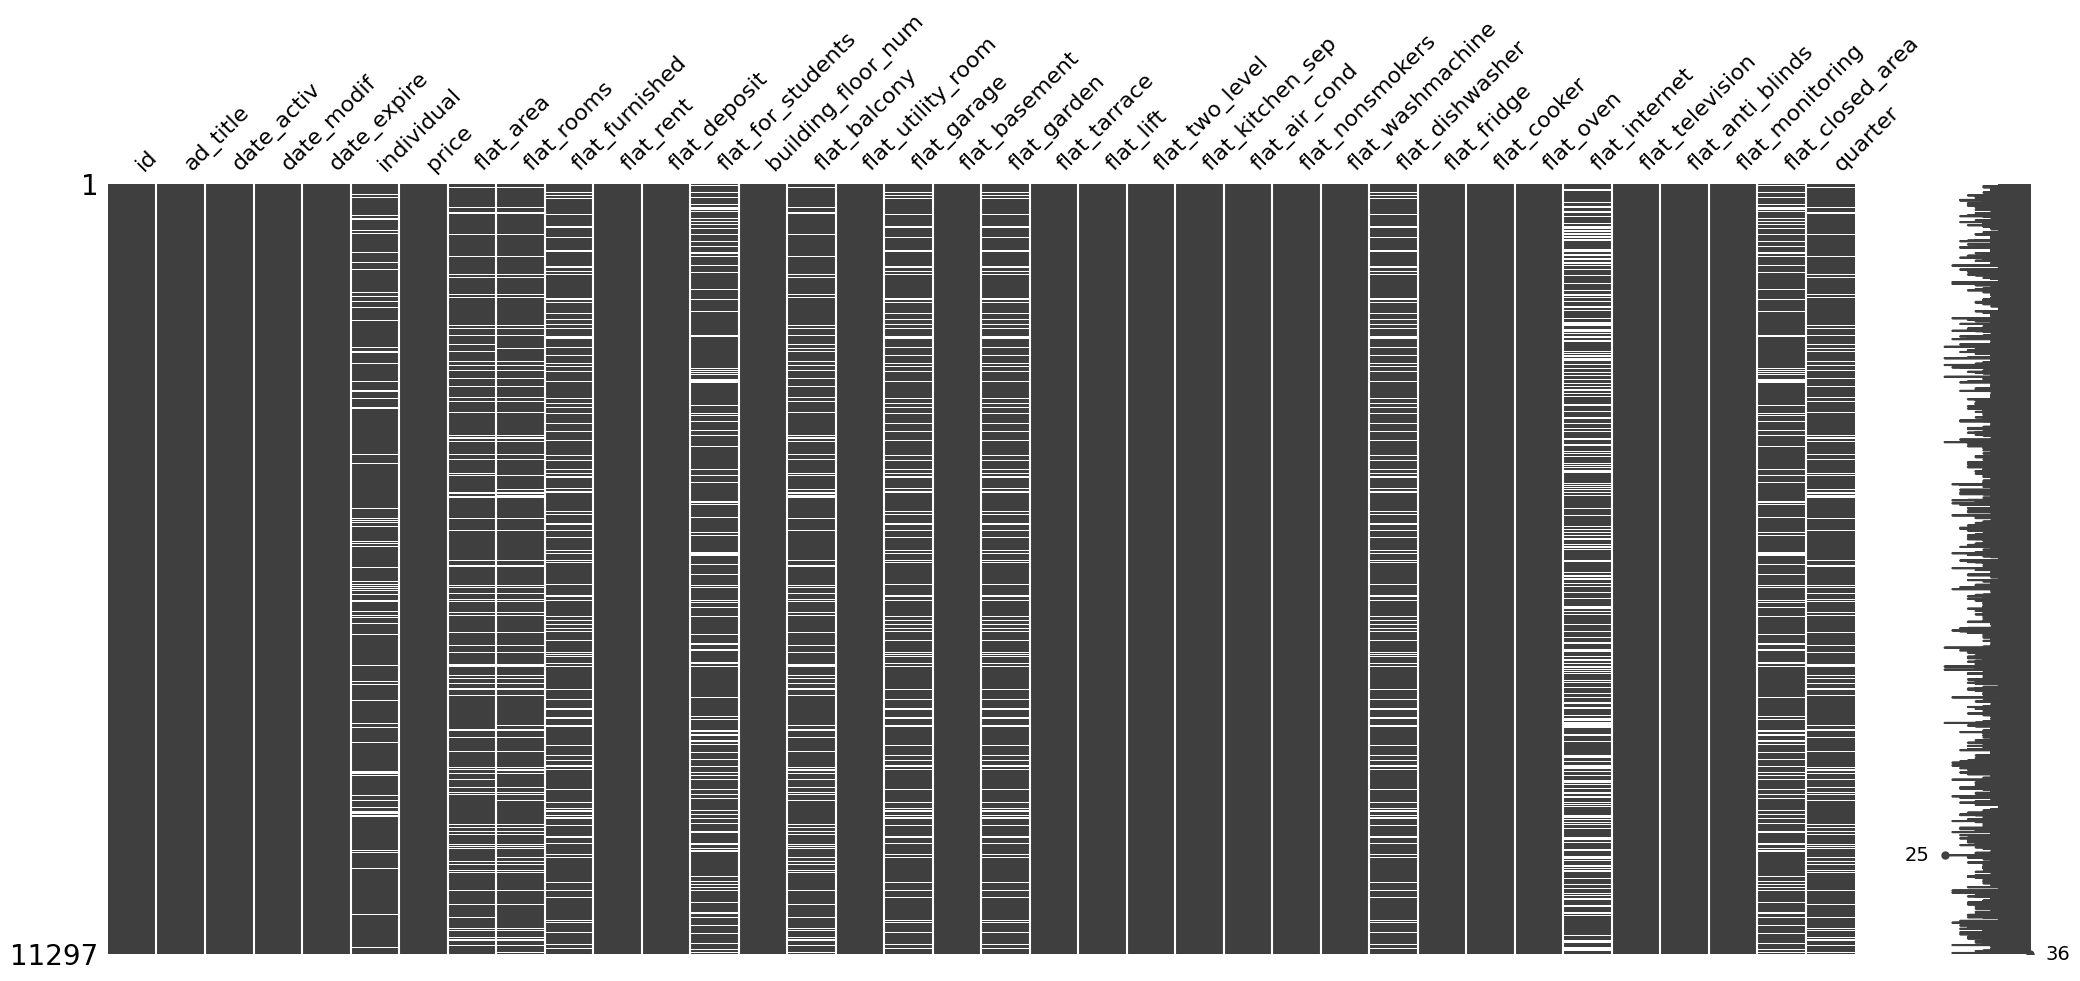

In [16]:
msno.matrix(train)
plt.show()

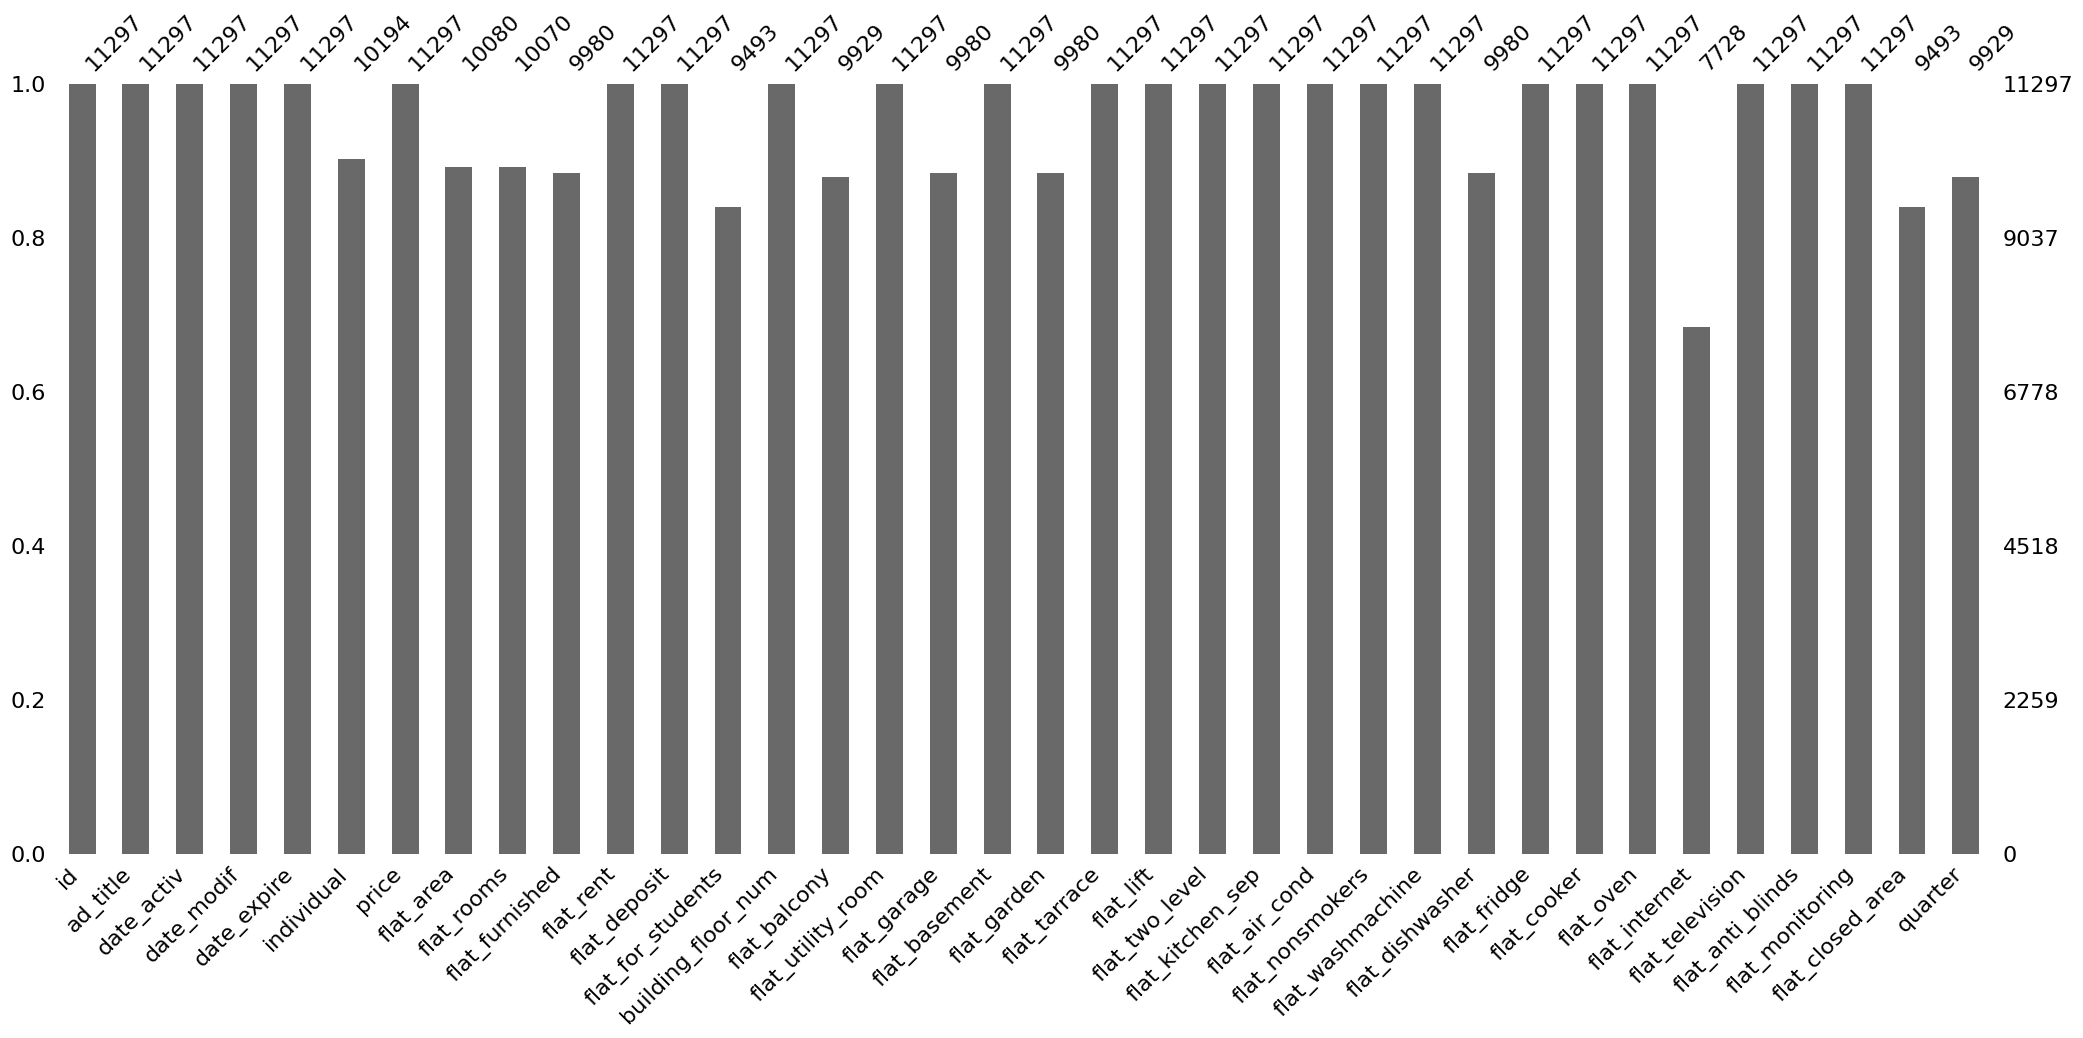

In [17]:
msno.bar(train)
plt.show()

<Axes: >

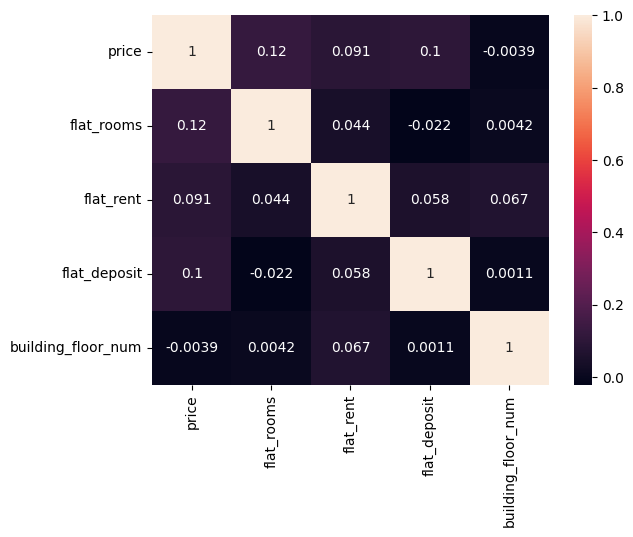

In [18]:
sns.heatmap(train[['price', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']].corr(), annot=True)

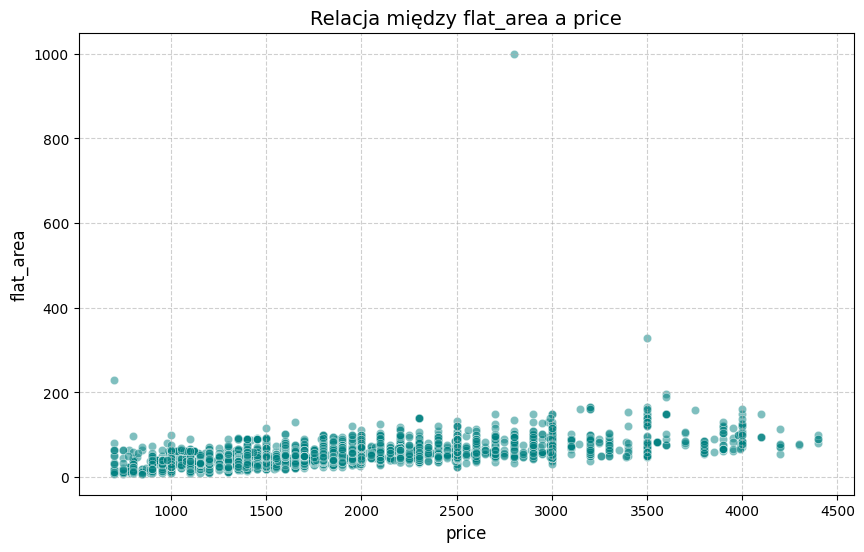

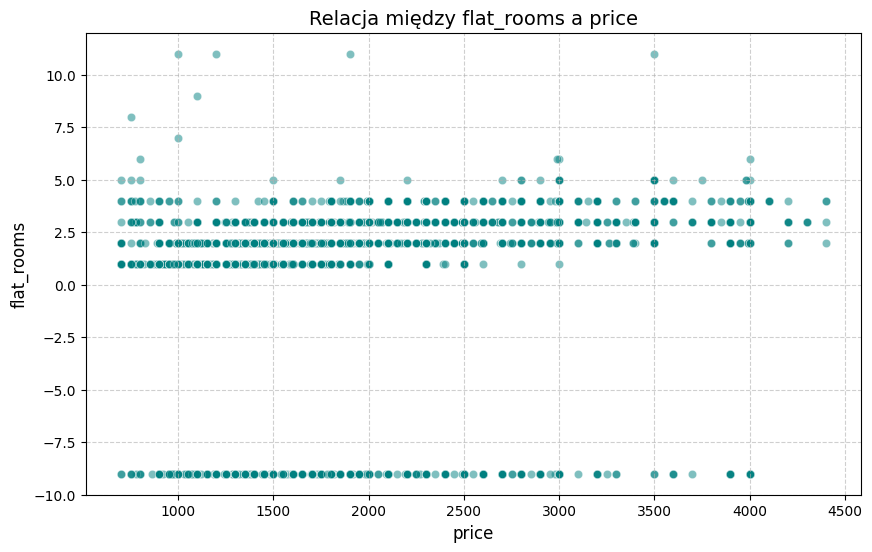

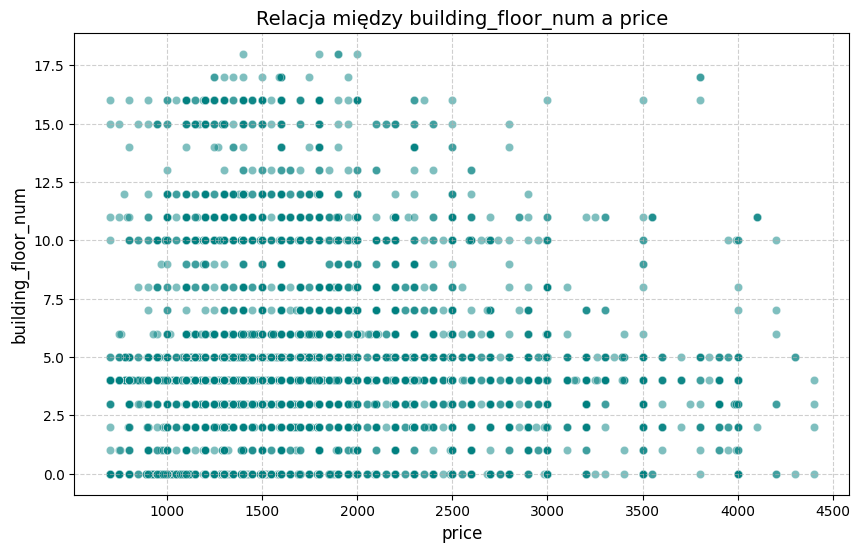

In [19]:
train_clean = train.replace(-999, np.nan)

#zmienne numeryczne 
cols_to_plot = ['flat_area', 'flat_rooms', 'building_floor_num']

for col in cols_to_plot:
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(data=train_clean, x='price', y=col, alpha=0.5, color='teal')
    
    plt.title(f'Relacja między {col} a price', fontsize=14)
    plt.xlabel(f'price', fontsize=12)
    plt.ylabel(f'{col}', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.show()

In [20]:
print(train_clean['flat_rent'].describe())
print(train_clean['flat_deposit'].describe())

count    11297.000000
mean       286.686642
std        542.004637
min          0.000000
25%          0.000000
50%        310.000000
75%        460.000000
max      50000.000000
Name: flat_rent, dtype: float64
count     11297.000000
mean       1300.089820
std        5784.663857
min           0.000000
25%           0.000000
50%        1400.000000
75%        2000.000000
max      600067.000000
Name: flat_deposit, dtype: float64


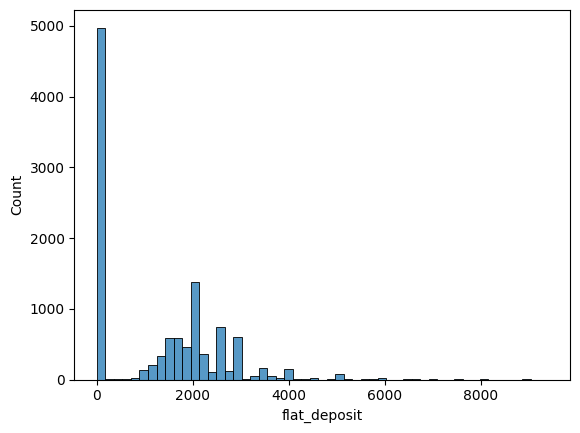

In [46]:
sns.histplot(
    data=train_clean[train_clean['flat_deposit'] < 10000], 
    x='flat_deposit', 
    bins='auto'
)
plt.show()

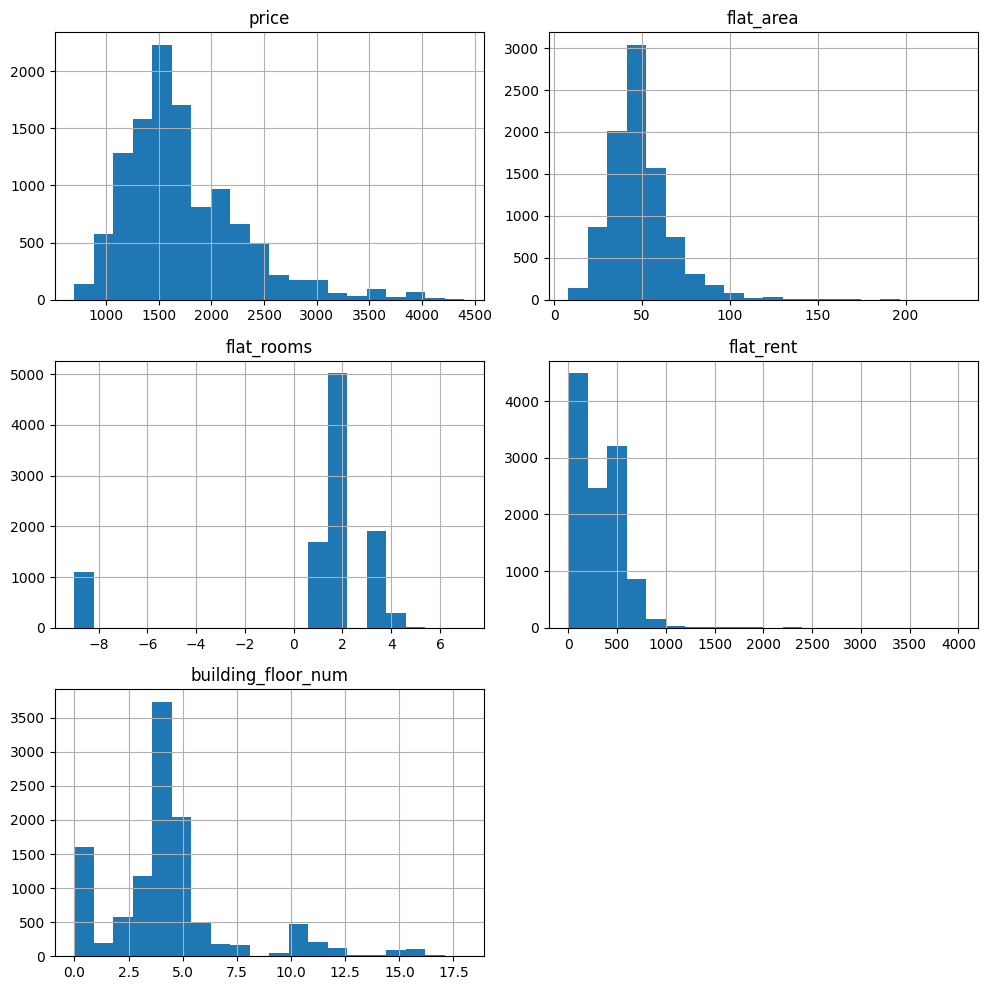

In [52]:
train_clean.select_dtypes(include='number').drop(columns=['id', 'flat_deposit']).hist(
    figsize=(10, 10), 
    bins=20
)
plt.tight_layout()
plt.show()

### Czyszczenie danych i imputacja odpowiednimi metodami oraz za pomocą wyrażeń regularnych REGEX

In [53]:
train_clean = train_clean[~((train_clean['flat_area'] > 900) & (train_clean['price'] < 3500))]
train_clean = train_clean[~((train_clean['flat_rooms'] >= 8) & (train_clean['flat_rooms'] < 0))]

@Martyna - to bym wywalił szczerze

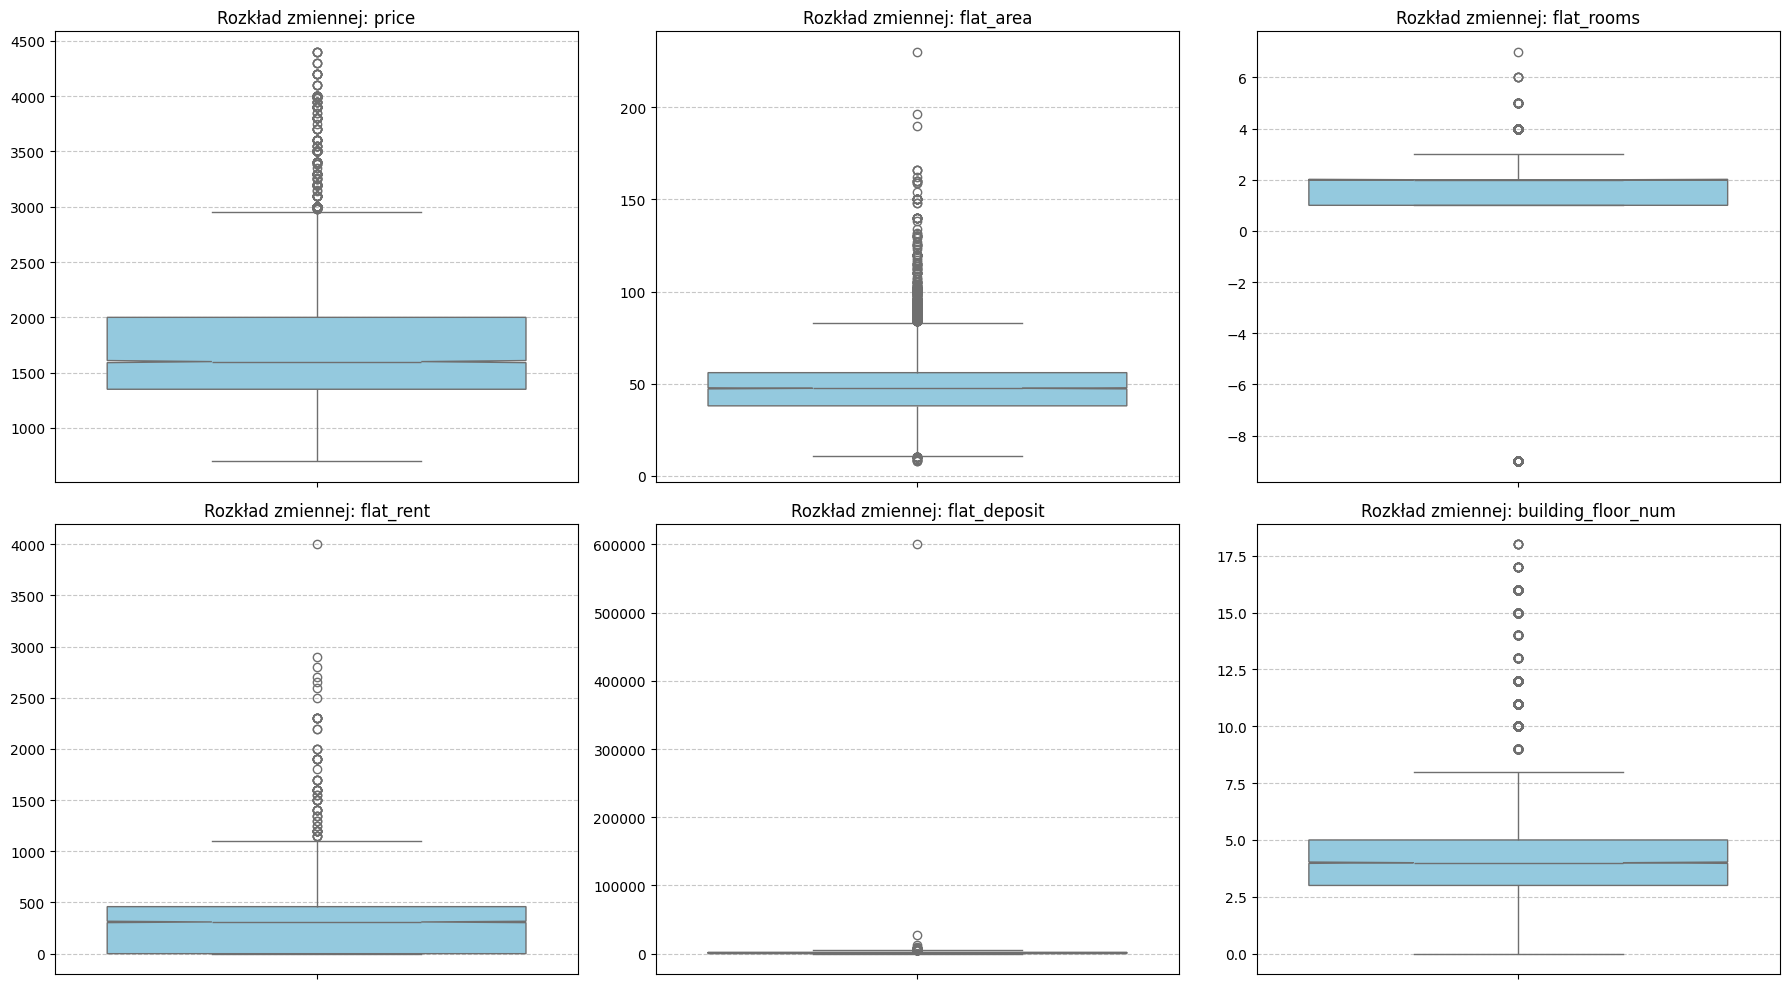

In [54]:
num_cols = ['price', 'flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten() 

for i, col in enumerate(num_cols):
    sns.boxplot(data=train_clean, y=col, ax=axes[i], color='skyblue', notch=True)
    axes[i].set_title(f'Rozkład zmiennej: {col}', fontsize=12)
    axes[i].set_ylabel('') 
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [55]:
def extract_area_from_title(title):
    if pd.isna(title):
        return np.nan
    
    # Wzorce "10 m2", "10.5 m2", "10,5 mkw", "10metrów"
    match = re.search(r'(\d+[.,]?\d*)\s*(m2|mkw|metr|m²|sqm)', str(title), re.IGNORECASE)
    
    if match:
        res = match.group(1).replace(',', '.') 
        try:
            return float(res)
        except:
            return np.nan
    return np.nan

train['flat_area'] = train['flat_area'].replace(-999, np.nan)

extracted_areas = train['ad_title'].apply(extract_area_from_title)

missing_before = train['flat_area'].isna().sum()
can_fix = (train['flat_area'].isna() & extracted_areas.notna()).sum()

train['flat_area'] = train['flat_area'].fillna(extracted_areas)

print(f"Liczba braków przed: {missing_before}")
print(f"Liczba uzupełnionych: {can_fix}")
print(f"Liczba braków po operacji: {train['flat_area'].isna().sum()}")


print(train['flat_area'].describe())

Liczba braków przed: 0
Liczba uzupełnionych: 0
Liczba braków po operacji: 0
count    11297.000000
mean        47.659638
std         19.488240
min          7.000000
25%         36.310000
50%         46.000000
75%         54.604000
max       1000.000000
Name: flat_area, dtype: float64


In [56]:
missing_flat_area = train[train['flat_area'].isna()]

print(missing_flat_area[['ad_title', 'flat_area']].head(30))

Empty DataFrame
Columns: [ad_title, flat_area]
Index: []


In [57]:
def extract_rooms_from_title(title):
    if pd.isna(title):
        return np.nan
    title_str = str(title).lower()
    
    # 1 pokój ==
    if 'kawalerka' in title_str or 'studio' in title_str or 'kawalerki' in title_str or 'kawalerkę' in title_str:
        return 1.0
    
    # 1 przed pokojem
    match = re.search(r'(\d+)\s*(?:[a-ząćęłńóśźż]+\s+)?-?pok', title_str)
    if match:
        return float(match.group(1))
    
    return np.nan

train['flat_rooms'] = train['flat_rooms'].replace(-9, np.nan)
extracted_rooms = train['ad_title'].apply(extract_rooms_from_title)

can_fix_rooms = (train['flat_rooms'].isna() & extracted_rooms.notna()).sum()
train['flat_rooms'] = train['flat_rooms'].fillna(extracted_rooms)

print(f"Uzupełniono flat_rooms: {can_fix_rooms}")
print(f"Liczba braków po operacji: {train['flat_rooms'].isna().sum()}")

Uzupełniono flat_rooms: 0
Liczba braków po operacji: 0


In [58]:
missing_flat_rooms = train[train['flat_rooms'].isna()]

print(missing_flat_rooms[['ad_title', 'flat_rooms']].head(30))

Empty DataFrame
Columns: [ad_title, flat_rooms]
Index: []


Podmianka dzielnicy z tytułu 

In [59]:
unique_quarters = train['quarter'].dropna().unique().tolist()
unique_quarters = sorted(unique_quarters, key=len, reverse=True)

def fill_quarter_from_title(row):
    if pd.notna(row['quarter']):
        return row['quarter']
    
    title = str(row['ad_title']).lower()
    for q in unique_quarters:
        if q.lower() in title:
            return q 
    return np.nan 

before_train = train['quarter'].isna().sum()
train['quarter'] = train.apply(fill_quarter_from_title, axis=1)
after_train = train['quarter'].isna().sum()

print(f"Uzupełniono {before_train - after_train} braków.")

Uzupełniono 0 braków.


Funkcja do sprawdzania dokładności metod imputacji i ich ewaluacji

In [60]:
def evaluate_imputation_methods(df, target_col, predictor_cols):
    data_complete = df.dropna(subset=[target_col] + predictor_cols).copy()
    
    X = data_complete[predictor_cols]
    y = data_complete[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results = {}

    #Średnia globalna
    y_pred_mean = np.full_like(y_test, y_train.mean())
    results['Średnia'] = np.sqrt(mean_squared_error(y_test, y_pred_mean))

    #Mediana globalna
    y_pred_med = np.full_like(y_test, y_train.median())
    results['Mediana'] = np.sqrt(mean_squared_error(y_test, y_pred_med))

    #Regresja Liniowa 
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred_lr = model_lr.predict(X_test)
    results['Regresja'] = np.sqrt(mean_squared_error(y_test, y_pred_lr))

    #KNN 
    knn = KNNImputer(n_neighbors=5)
    
    test_hidden = X_test.copy()
    test_hidden[target_col] = np.nan
    train_full = pd.concat([X_train, y_train], axis=1)
    
    
    imputed_data = knn.fit(train_full).transform(pd.concat([test_hidden, y_test.to_frame()], axis=0))
    y_pred_knn = imputed_data[:len(y_test), -1]
    results['KNN (k=5)'] = np.sqrt(mean_squared_error(y_test, y_pred_knn))

    return results


area_eval = evaluate_imputation_methods(train, 'flat_area', ['flat_rooms', 'price'])
print("Błędy dla flat_area:", area_eval)


rooms_eval = evaluate_imputation_methods(train, 'flat_rooms', ['flat_area', 'price'])
print("Błędy dla flat_rooms:", rooms_eval)

Błędy dla flat_area: {'Średnia': 16.347121656329257, 'Mediana': 16.38652485503802, 'Regresja': 10.028389754333686, 'KNN (k=5)': 11.128318172003581}
Błędy dla flat_rooms: {'Średnia': 0.7647171221933574, 'Mediana': 0.7645346783085011, 'Regresja': 0.5153850800187324, 'KNN (k=5)': 0.49301313055805607}


In [61]:
test.replace(-999, np.nan, inplace=True)
test.replace(-9, np.nan, inplace=True)
num_cols_test = test.select_dtypes(include=[np.number]).columns
for col in num_cols_test:
    test.loc[test[col] < 0, col] = np.nan

extracted_area_test = test['ad_title'].apply(extract_area_from_title)
test['flat_area'] = test['flat_area'].fillna(extracted_area_test)


extracted_rooms_test = test['ad_title'].apply(extract_rooms_from_title)
test['flat_rooms'] = test['flat_rooms'].fillna(extracted_rooms_test)

print("Brakujące wartości w zbiorze test")
print(test[['flat_area', 'flat_rooms']].isna().sum())

Brakujące wartości w zbiorze test
flat_area     0
flat_rooms    0
dtype: int64


In [62]:
for df in [train, test]:
    df.replace([-999, -9], np.nan, inplace=True)
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        df.loc[df[col] < 0, col] = np.nan
    
    df['flat_area'] = df['flat_area'].fillna(df['ad_title'].apply(extract_area_from_title))
    df['flat_rooms'] = df['flat_rooms'].fillna(df['ad_title'].apply(extract_rooms_from_title))


In [63]:
impute_features = ['flat_area', 'flat_rooms', 'flat_rent']

imputer = KNNImputer(n_neighbors=5)

imputer.fit(train[impute_features])

train[impute_features] = imputer.transform(train[impute_features])

test[impute_features] = imputer.transform(test[impute_features])

train['flat_rooms'] = train['flat_rooms'].round()
test['flat_rooms'] = test['flat_rooms'].round()

print("Braki")
print(f"Train flat_area: {train['flat_area'].isna().sum()}")
print(f"Test flat_area: {test['flat_area'].isna().sum()}")

Braki
Train flat_area: 0
Test flat_area: 0


In [64]:
print(train[['flat_area', 'flat_rooms']].describe())

          flat_area    flat_rooms
count  11297.000000  11297.000000
mean      47.659638      1.986191
std       19.488240      0.789104
min        7.000000      1.000000
25%       36.310000      1.000000
50%       46.000000      2.000000
75%       54.604000      2.000000
max     1000.000000     11.000000


In [65]:
print(train[['flat_area', 'flat_rooms']].head())

   flat_area  flat_rooms
0       49.0         2.0
1       65.0         3.0
2       30.0         1.0
3       10.0         1.0
4       47.0         2.0


In [66]:
for df in [train, test]:
    
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        df.loc[df[col] < 0, col] = np.nan
    
    df['flat_area'] = df['flat_area'].fillna(df['ad_title'].apply(extract_area_from_title))
    df['flat_rooms'] = df['flat_rooms'].fillna(df['ad_title'].apply(extract_rooms_from_title))

impute_features = ['flat_deposit', 'building_floor_num', 'flat_rent']

impute_features = [col for col in impute_features if col in train.columns and col in test.columns]


imputer = KNNImputer(n_neighbors=5)
imputer.fit(train[impute_features])

train[impute_features] = imputer.transform(train[impute_features])
test[impute_features] = imputer.transform(test[impute_features])

for col in ['building_floor_num']:
    if col in train.columns:
        train[col] = train[col].round()
        test[col] = test[col].round()

print("Pozostałe braki po imputacji KNN:")
print("Zbiór TRAIN:")
print(train[impute_features].isna().sum())
print("Zbiór TEST:")
print(test[impute_features].isna().sum())

Pozostałe braki po imputacji KNN:
Zbiór TRAIN:
flat_deposit          0
building_floor_num    0
flat_rent             0
dtype: int64
Zbiór TEST:
flat_deposit          0
building_floor_num    0
flat_rent             0
dtype: int64


In [67]:
print(train[['flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']].describe())

          flat_area    flat_rooms     flat_rent   flat_deposit  \
count  11297.000000  11297.000000  11297.000000   11297.000000   
mean      47.659638      1.986191    286.686642    1300.089820   
std       19.488240      0.789104    542.004637    5784.663857   
min        7.000000      1.000000      0.000000       0.000000   
25%       36.310000      1.000000      0.000000       0.000000   
50%       46.000000      2.000000    310.000000    1400.000000   
75%       54.604000      2.000000    460.000000    2000.000000   
max     1000.000000     11.000000  50000.000000  600067.000000   

       building_floor_num  
count        11297.000000  
mean             4.295477  
std              3.094300  
min              0.000000  
25%              3.000000  
50%              4.000000  
75%              5.000000  
max             18.000000  


In [68]:
print(train['flat_deposit'].nlargest(5))

6927    600067.0
1252     28000.0
1153     12400.0
5321      9400.0
5439      9000.0
Name: flat_deposit, dtype: float64


In [69]:
print(train['flat_rent'].nlargest(5))

65      50000.0
8135     4000.0
5378     2900.0
725      2800.0
590      2700.0
Name: flat_rent, dtype: float64


In [70]:
print(train.columns)

Index(['id', 'ad_title', 'date_activ', 'date_modif', 'date_expire',
       'individual', 'price', 'flat_area', 'flat_rooms', 'flat_furnished',
       'flat_rent', 'flat_deposit', 'flat_for_students', 'building_floor_num',
       'flat_balcony', 'flat_utility_room', 'flat_garage', 'flat_basement',
       'flat_garden', 'flat_tarrace', 'flat_lift', 'flat_two_level',
       'flat_kitchen_sep', 'flat_air_cond', 'flat_nonsmokers',
       'flat_washmachine', 'flat_dishwasher', 'flat_fridge', 'flat_cooker',
       'flat_oven', 'flat_internet', 'flat_television', 'flat_anti_blinds',
       'flat_monitoring', 'flat_closed_area', 'quarter'],
      dtype='object')


In [71]:
cat_cols_to_impute = ['individual', 'flat_furnished','flat_for_students', 'flat_balcony', 'flat_utility_room', 'flat_garage', 'flat_basement',
       'flat_garden', 'flat_tarrace', 'flat_lift', 'flat_two_level','flat_kitchen_sep', 'flat_air_cond', 'flat_nonsmokers',
       'flat_washmachine', 'flat_dishwasher', 'flat_fridge', 'flat_cooker','flat_oven', 'flat_internet', 'flat_television', 'flat_anti_blinds',
       'flat_monitoring', 'flat_closed_area']
predictors = ['flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']

for target_col in cat_cols_to_impute:
    if target_col not in train.columns:
        continue
    
    train_complete = train.dropna(subset=[target_col] + predictors).copy()
    
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(train_complete[target_col].astype(str))
    X_train = train_complete[predictors]
    

    model_log = LogisticRegression(max_iter=1000)
    model_log.fit(X_train, y_train_encoded)
    

    mask_train = train[target_col].isna() & train[predictors].notna().all(axis=1)
    if mask_train.any():
        preds_train = model_log.predict(train.loc[mask_train, predictors])
        train.loc[mask_train, target_col] = le.inverse_transform(preds_train)
        

    mask_test = test[target_col].isna() & test[predictors].notna().all(axis=1)
    if mask_test.any():
        preds_test = model_log.predict(test.loc[mask_test, predictors])
        test.loc[mask_test, target_col] = le.inverse_transform(preds_test)


    mode_val = train[target_col].mode()[0]
    train[target_col] = train[target_col].fillna(mode_val)
    test[target_col] = test[target_col].fillna(mode_val)

print(f"Braki w TRAIN:\n{train[cat_cols_to_impute].isna().sum()}")
print(f"Braki w TEST:\n{test[cat_cols_to_impute].isna().sum()}")

Braki w TRAIN:
individual           0
flat_furnished       0
flat_for_students    0
flat_balcony         0
flat_utility_room    0
flat_garage          0
flat_basement        0
flat_garden          0
flat_tarrace         0
flat_lift            0
flat_two_level       0
flat_kitchen_sep     0
flat_air_cond        0
flat_nonsmokers      0
flat_washmachine     0
flat_dishwasher      0
flat_fridge          0
flat_cooker          0
flat_oven            0
flat_internet        0
flat_television      0
flat_anti_blinds     0
flat_monitoring      0
flat_closed_area     0
dtype: int64
Braki w TEST:
individual           0
flat_furnished       0
flat_for_students    0
flat_balcony         0
flat_utility_room    0
flat_garage          0
flat_basement        0
flat_garden          0
flat_tarrace         0
flat_lift            0
flat_two_level       0
flat_kitchen_sep     0
flat_air_cond        0
flat_nonsmokers      0
flat_washmachine     0
flat_dishwasher      0
flat_fridge          0
flat_cooker    

In [72]:
def impute_quarter_knn(train, test):
    predictors = ['flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit', 'building_floor_num']
    target = 'quarter'
    
  
    le = LabelEncoder()
    all_quarters = pd.concat([train[target].dropna(), test[target].dropna()]).astype(str)
    le.fit(all_quarters)
    
    global_mode = train[target].mode()[0]
    mode_id = le.transform([global_mode])[0]
    
    imputer = KNNImputer(n_neighbors=5)
    
    train_for_fit = train[predictors].copy()
    train_for_fit[target] = np.nan
    mask_train_known = train[target].notna()
    train_for_fit.loc[mask_train_known, target] = le.transform(train.loc[mask_train_known, target].astype(str))
    
    imputer.fit(train_for_fit)
    
    for df in [train, test]:
        temp_data = df[predictors].copy()
        temp_data[target] = np.nan
        
        known_mask = df[target].notna()
        temp_data.loc[known_mask, target] = le.transform(df.loc[known_mask, target].astype(str))
        
        imputed_array = imputer.transform(temp_data)
        
        encoded_preds = imputed_array[:, -1]
        
        encoded_preds = np.where(np.isnan(encoded_preds), mode_id, encoded_preds)
        
        encoded_preds = np.round(encoded_preds).astype(int)
        encoded_preds = np.clip(encoded_preds, 0, len(le.classes_) - 1)
        
        final_names = le.inverse_transform(encoded_preds)
        
        df[target] = final_names
        
    return train, test


train, test = impute_quarter_knn(train, test)


print(f"Braki w Train: {train['quarter'].isna().sum()}")
print(f"Braki w Test: {test['quarter'].isna().sum()}")

Braki w Train: 0
Braki w Test: 0


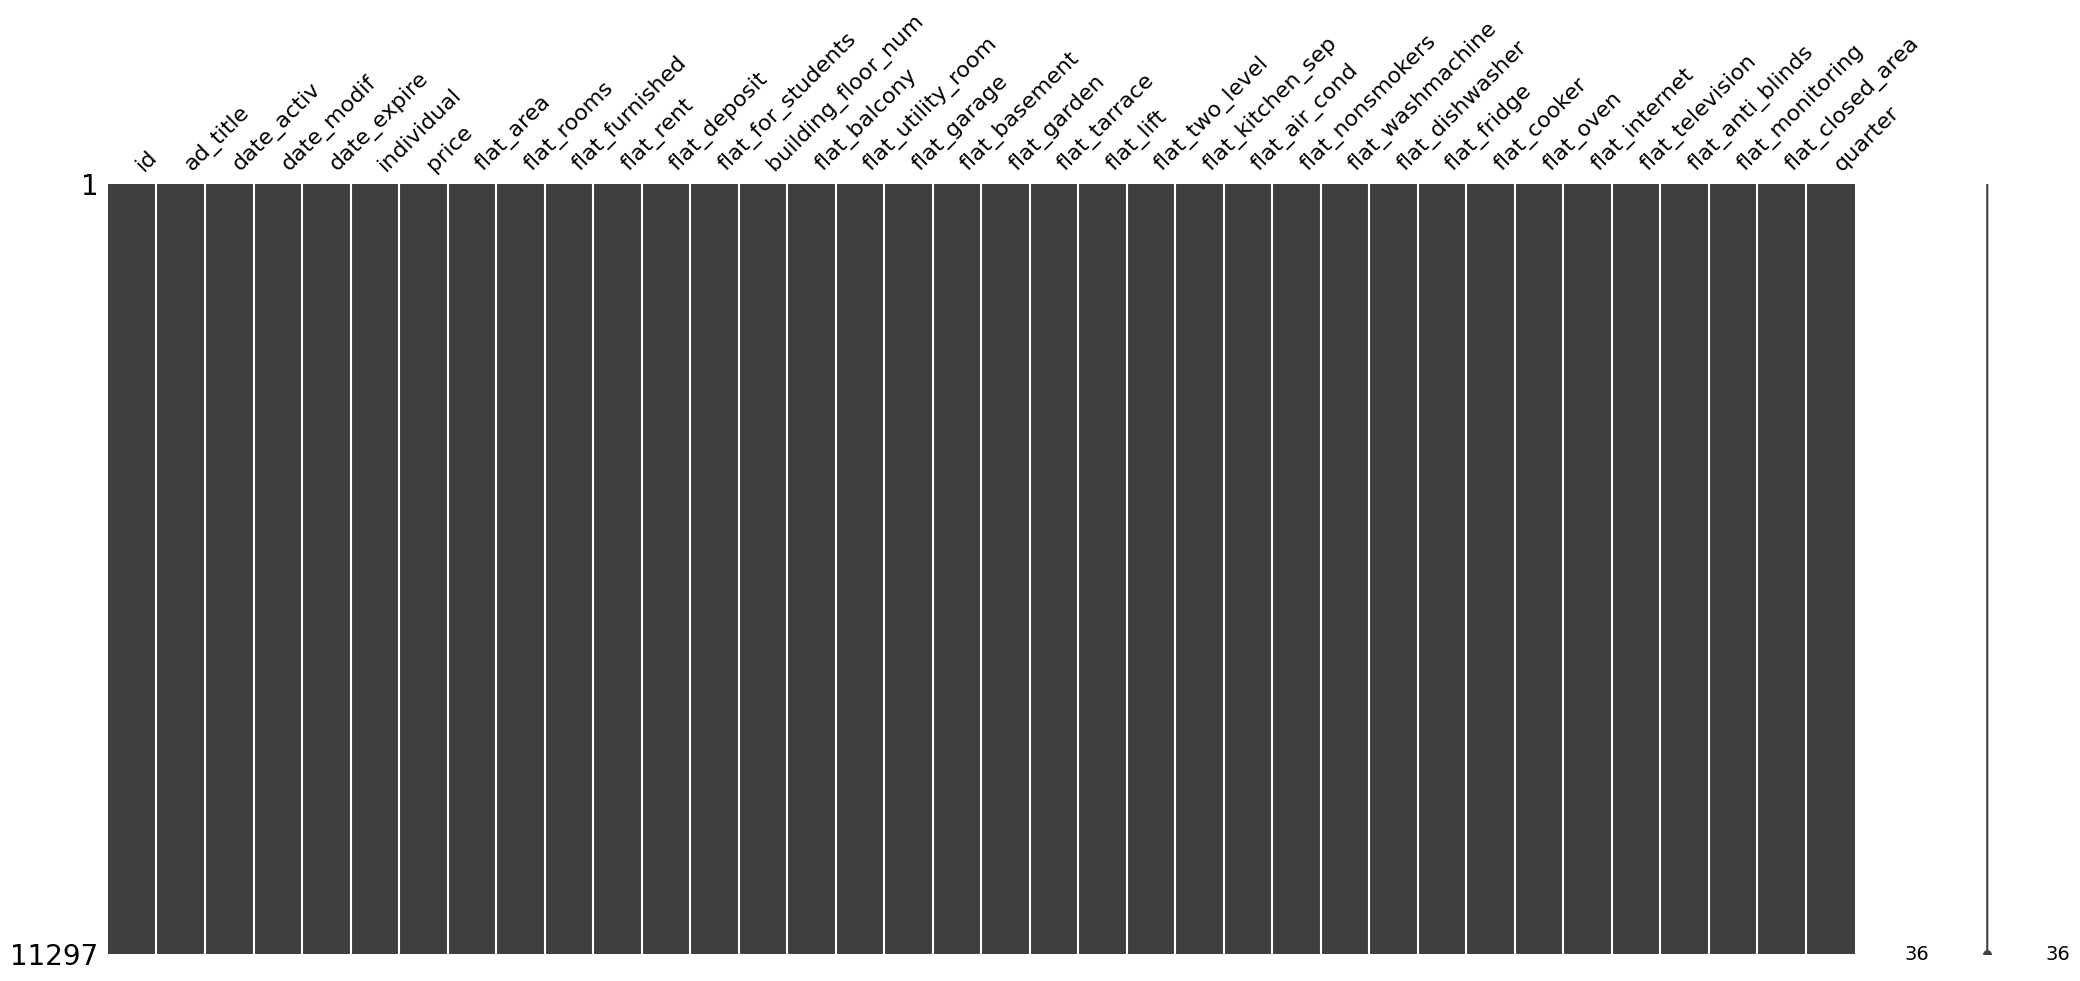

In [73]:
msno.matrix(train)
plt.show()

In [74]:
print(train['quarter'].unique())

['Rataje' 'Piątkowo' 'Wilda' 'Strzeszyn' 'Winogrady' 'Centrum' 'Łazarz'
 'Komandoria' 'Grunwald' 'Raszyn' 'Marcelin' 'Malta' 'Jeżyce' 'Podolany'
 'Rynek Wildecki' 'Sołacz' 'Górna Wilda' 'Górczyn' 'Stare Miasto'
 'Rynek Łazarski' 'Garbary' 'Nowe Miasto' 'Dębiec' 'Chartowo'
 'Rynek Jeżycki' 'Naramowice' 'Winiary' 'Umultowo' 'Stary Rynek' 'Pogodno'
 'Ogrody' 'Kopanina' 'Junikowo' 'Kobyle Pole' 'Dolna Wilda' 'Świerczewo'
 'Wilczak' 'Warszawskie' 'Zawady' 'Chwaliszewo' 'Żegrze' 'Starołęka'
 'Piekary' 'Zieliniec' 'Główna' 'Naramowickie Osiedle' 'Wola'
 'Krzyżowniki' 'Ławica' 'Ostrów Tumski' 'Piotrowo' 'Nadolnik' 'Fabianowo'
 'Krzesiny' 'Radojewo' 'Smochowice' 'Morasko' 'Starołęka Mała' 'Śródka'
 'Bonin' 'Pokrzywno' 'Święty Roch' 'Biała Góra' 'Antoninek' 'Spławie'
 'Minikowo' 'Edwardowo' 'Strzeszynek' 'Franowo' 'Karolin' 'Wilczy Młyn'
 'Szeląg' 'Marlewo' 'Kotowo' 'Szczepankowo' 'Głuszyna' 'Bajkowe'
 'Czekalskie']


In [75]:
print(train.isna().sum())

id                    0
ad_title              0
date_activ            0
date_modif            0
date_expire           0
individual            0
price                 0
flat_area             0
flat_rooms            0
flat_furnished        0
flat_rent             0
flat_deposit          0
flat_for_students     0
building_floor_num    0
flat_balcony          0
flat_utility_room     0
flat_garage           0
flat_basement         0
flat_garden           0
flat_tarrace          0
flat_lift             0
flat_two_level        0
flat_kitchen_sep      0
flat_air_cond         0
flat_nonsmokers       0
flat_washmachine      0
flat_dishwasher       0
flat_fridge           0
flat_cooker           0
flat_oven             0
flat_internet         0
flat_television       0
flat_anti_blinds      0
flat_monitoring       0
flat_closed_area      0
quarter               0
dtype: int64
